In [1]:
from typing import NamedTuple

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from doe_modules.design import CLOO, PlackettBurman, FullFactorial, DOptimization, d_criterion, DOCLOO
from doe_modules.plot import correlation_heatmap, design_heatmap, bio_scatterview
from doe_modules.preferences import kwarg_savefig, outputdir, heatmap_pref, dsmat_pref, textcolor
from doe_modules.preferences.cmap import sim1
from doe_modules.simulation import Sim1, MLR

In [2]:
class Config(NamedTuple):
    savefig: bool = True
    out: str = outputdir

conf = Config()

/home/jovyan/jupyternb/doe_modules/plot/_design_matrix.py:29: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=dsm.applymap(


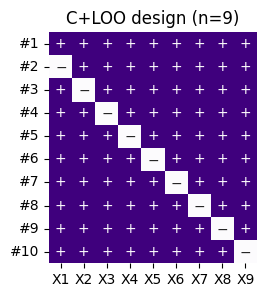

In [3]:
fig, ax = plt.subplots(figsize=(3, 3))

n_factor = 9

design_heatmap(
    design=CLOO, n_factor=n_factor, ax=ax, **dsmat_pref
)

if conf.savefig:
    fig.savefig(f"{conf.out}/n={n_factor}.pdf", **kwarg_savefig)

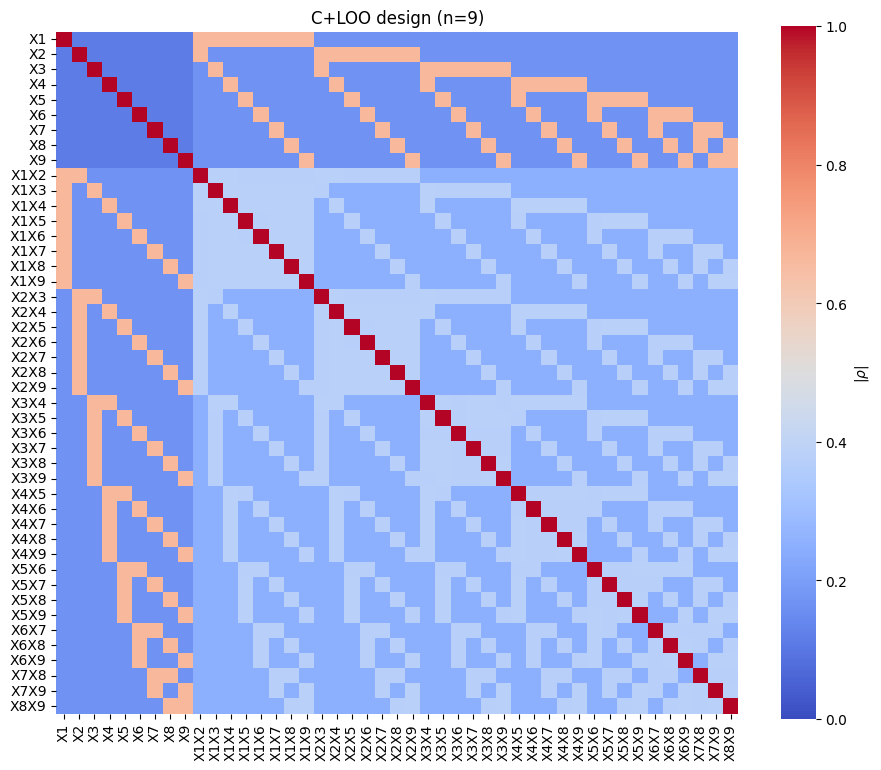

In [4]:
fig, ax = plt.subplots(figsize=(11, 9))

correlation_heatmap(
    design=CLOO, n_factor=9, ax=ax, **heatmap_pref
)

if conf.savefig:
    fig.savefig(f"{conf.out}/corr_n={n_factor}.pdf", **kwarg_savefig)

- if you wish to have part-by-part visualizations

In [5]:
# fig, ax = plt.subplots(figsize=(3, 3))

# sns.heatmap(
#     CLOO().get_exmatrix(9)().corr().abs(), ax=ax, **heatmap_pref
# )

# ax.set(title="Main effects \nvs main effects")

# if conf.savefig:
#     fig.savefig(f"{conf.out}/main_n={n_factor}", **kwarg_savefig)

In [6]:
# fig, ax = plt.subplots(figsize=(9, 2))

# sns.heatmap(
#     CLOO().get_exmatrix(9).interactions().corr().abs().iloc[:9, 9:], 
#     ax=ax, **heatmap_pref
# )

# ax.set(title="Main effects vs interaction terms")

# if conf.savefig:
#     fig.savefig(f"{conf.out}/m&i_n={n_factor}", **kwarg_savefig)

In [7]:
# fig, ax = plt.subplots(figsize=(9, 7))

# sns.heatmap(
#     CLOO().get_exmatrix(9).interactions().corr().abs().iloc[9:, 9:], 
#     ax=ax, **heatmap_pref
# )

# ax.set(title="Interaction terms vs interaction terms")

# if conf.savefig:
#     fig.savefig(f"{conf.out}/interaction_n={n_factor}", **kwarg_savefig)

- if you wish to see correlation heatmaps for other ns

In [8]:
# for n_f in [2, 3, 4, 5, 6, 7, 8]:
#     fig, ax = plt.subplots(figsize=(n_f+2, n_f))

#     correlation_heatmap(
#         design=CLOO, n_factor=n_f, ax=ax, **heatmap_pref
#     )
#     ax.set_title(f"C+LOO design (n={n_f})", fontsize="medium" if n_f == 2 else "large")
    
#     if conf.savefig:
#         fig.savefig(f"{conf.out}/n={n_f}", **kwarg_savefig)

In [9]:
def main1_1(x: int) -> float:
    return 1 if x >= 1 else np.nan

def main1_2(x: int) -> float:
    return - 1 / x if x >= 2 else np.nan

def main1_int12(x: int) -> float:
    return np.sqrt((x - 1) / (2 * x)) if x >= 2 else np.nan

def main1_int23(x: int) -> float:
    return -np.sqrt(2 / (x * (x - 1))) if x >= 3 else np.nan

def int12_12(x: int) -> float:
    return 1 if x >= 1 else np.nan

def int12_13(x: int) -> float:
    return (x - 3) / (2 * (x - 1)) if x >= 3 else np.nan

def int12_34(x: int) -> float:
    return -2 / (x - 1) if x >= 4 else np.nan

In [10]:
m1m1 = np.vectorize(main1_1)
m1m2 = np.vectorize(main1_2)
m1i12 = np.vectorize(main1_int12)
m1i23 = np.vectorize(main1_int23)
i12i12 = np.vectorize(int12_12)
i12i13 = np.vectorize(int12_13)
i12i34 = np.vectorize(int12_34)

In [11]:
n = np.arange(12) + 1

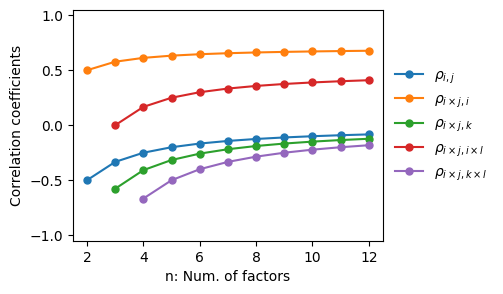

In [12]:
fig, ax = plt.subplots(figsize=(4, 3))

ax.plot(n, m1m2(n), label=r"$\rho_{i,j}$", marker="o", markersize=5)
ax.plot(n, m1i12(n), label=r"$\rho_{i\times j,i}$", marker="o", markersize=5)
ax.plot(n, m1i23(n), label=r"$\rho_{i\times j,k}$", marker="o", markersize=5)
ax.plot(n, i12i13(n), label=r"$\rho_{i\times j,i\times l}$", marker="o", markersize=5)
ax.plot(n, i12i34(n), label=r"$\rho_{i\times j,k\times l}$", marker="o", markersize=5)

ax.set_ylim(-1.05, 1.05)
ax.legend(loc="center left", bbox_to_anchor=(1, .5), frameon=False)
ax.set(ylabel="Correlation coefficients", xlabel="n: Num. of factors");

# if conf.savefig:
#         fig.savefig(f"{conf.out}/corr", **kwarg_savefig)

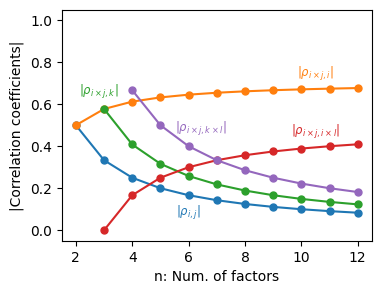

In [13]:
fig, ax = plt.subplots(figsize=(4, 3))

ax.plot(n, np.abs(m1m2(n)), label=r"$|\rho_{i,j}|$", marker="o", markersize=5)
ax.plot(n, np.abs(m1i12(n)), label=r"$|\rho_{i\times j,i}|$", marker="o", markersize=5)
ax.plot(n, np.abs(m1i23(n)), label=r"$|\rho_{i\times j,k}|$", marker="o", markersize=5)
ax.plot(n, np.abs(i12i13(n)), label=r"$|\rho_{i\times j,i\times l}|$", marker="o", markersize=5)
ax.plot(n, np.abs(i12i34(n)), label=r"$|\rho_{i\times j,k\times l}|$", marker="o", markersize=5)

ax.set_ylim(-.05, 1.05)

ax.text(6, np.abs(m1m2(n))[5] - .04, r"$|\rho_{i,j}|$", ha="center", va="top", color="C0", size="small")
ax.text(10.5, np.abs(m1i12(n))[-3:-1].mean() + .03, r"$|\rho_{i\times j,i}|$", ha="center", va="bottom", color="C1", size="small")
ax.text(3.5, np.abs(m1i23(n))[2] + .04, r"$|\rho_{i\times j,k}|$", ha="right", va="bottom", color="C2", size="small")
ax.text(10.5, np.abs(i12i13(n))[-3:-1].mean() + .03, r"$|\rho_{i\times j,i\times l}|$", ha="center", va="bottom", color="C3", size="small")
ax.text(5.5, np.abs(i12i34(n))[5] + .04, r"$|\rho_{i\times j,k\times l}|$", ha="left", va="bottom", color="C4", size="small")

ax.set(ylabel="|Correlation coefficients|", xlabel="n: Num. of factors")
ax.set_xticks(range(2, 13, 2))

if conf.savefig:
        fig.savefig(f"{conf.out}/corr_abs.pdf", **kwarg_savefig)

In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

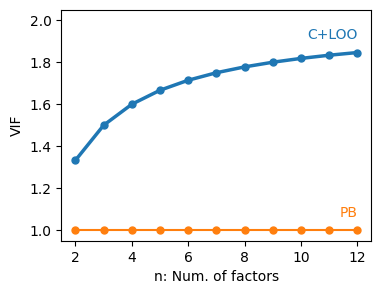

In [15]:
fig, ax = plt.subplots(figsize=(4, 3))

vif_cloo = np.vectorize(lambda n: vif(sm.add_constant(CLOO().get_exmatrix(n)().values), 1))
vif_pb = np.vectorize(lambda n: vif(sm.add_constant(PlackettBurman().get_exmatrix(n)().values), 1))

x = np.arange(2, 13)
y_cloo, y_pb = vif_cloo(x), vif_pb(x)

ax.plot(x, y_cloo, marker="o", markersize=5, c="C0", label="C+LOO", linewidth=2.5)
ax.plot(x, y_pb, marker="o", markersize=5, c="C1", label="PB")
ax.set_ylim(.95, 2.05)
ax.set(ylabel="VIF", xlabel="n: Num. of factors")
ax.set_xticks(range(2, 13, 2))

ax.text(12, y_cloo[-1] + .05, "C+LOO", ha="right", va="bottom", color="C0")
ax.text(12, y_pb[-1] + .05, "PB", ha="right", va="bottom", color="C1")
    
if conf.savefig:
        fig.savefig(f"{conf.out}/vif.pdf", **kwarg_savefig)

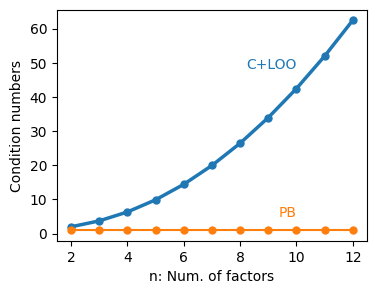

In [16]:
fig, ax = plt.subplots(figsize=(4, 3))

cond_cloo = np.vectorize(lambda n: np.linalg.cond(sm.add_constant(CLOO().get_exmatrix(n)().values)))
cond_pb = np.vectorize(lambda n: np.linalg.cond(sm.add_constant(PlackettBurman().get_exmatrix(n)().values)))

x = np.arange(2, 13)
y_cloo, y_pb = cond_cloo(x), cond_pb(x)

ax.plot(x, y_cloo, marker="o", markersize=5, c="C0", label="C+LOO", linewidth=2.5)
ax.plot(x, y_pb, marker="o", markersize=5, c="C1", label="PB")

ax.set(ylabel="Condition numbers", xlabel="n: Num. of factors")
ax.set_xticks(range(2, 13, 2))

ax.text(10, y_cloo[-3] + 5, "C+LOO", ha="right", va="bottom", color="C0")
ax.text(10, y_pb[-3] + 3, "PB", ha="right", va="bottom", color="C1")

if conf.savefig:
        fig.savefig(f"{conf.out}/condition_number.pdf", **kwarg_savefig)

In [17]:
def interaction_absorption(design, n_factor, order, n_rep=1):
    X = design().get_exmatrix(n_factor)
    P = lambda mat: mat @ np.linalg.inv(mat.T @ mat) @ mat.T
    PX = P(sm.add_constant(np.vstack([X().values] * n_rep)))
    X_int = np.vstack([X.interactions(order).iloc[:, n_factor:].values] * n_rep)
    return np.trace(X_int.T @ PX @ X_int) / np.trace(X_int.T @ X_int)

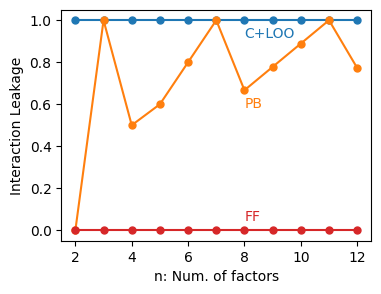

In [18]:
fig, ax = plt.subplots(figsize=(4, 3))

x = np.arange(2, 13)
abs_cloo = np.vectorize(lambda n: interaction_absorption(CLOO, n, 2))(x)
abs_pb = np.vectorize(lambda n: interaction_absorption(PlackettBurman, n, 2))(x)
abs_ff = np.vectorize(lambda n: interaction_absorption(FullFactorial, n, 2))(x)

ax.plot(x, abs_cloo, marker="o", markersize=5, label="C+LOO")
ax.plot(x, abs_pb, marker="o", markersize=5, label="PB")
ax.plot(x, abs_ff, marker="o", markersize=5, label="FF", color="C3")

ax.set(ylabel="Interaction Leakage", xlabel="n: Num. of factors")
# ax.legend()

ax.text(8, abs_cloo[-5] - .03, "C+LOO", ha="left", va="top", color="C0")
ax.text(8, abs_pb[-5] - .03, "PB", ha="left", va="top", color="C1")
ax.text(8, abs_ff[-5] + .03, "FF", ha="left", va="bottom", color="C3")

ax.set_xticks(range(2, 13, 2))
    
if conf.savefig:
    fig.savefig(f"{conf.out}/interaction_leakage.pdf", **kwarg_savefig)

---
# PB

/home/jovyan/jupyternb/doe_modules/plot/_design_matrix.py:29: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=dsm.applymap(


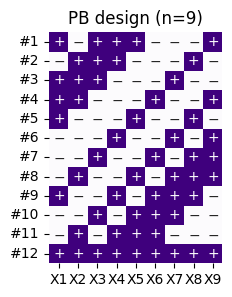

In [19]:
fig, ax = plt.subplots(figsize=(3, 3))

n_factor = 9

design_heatmap(
    design=PlackettBurman, n_factor=n_factor, ax=ax,
    **dsmat_pref
)

if conf.savefig:
    fig.savefig(f"{conf.out}/pb_n={n_factor}.pdf", **kwarg_savefig)

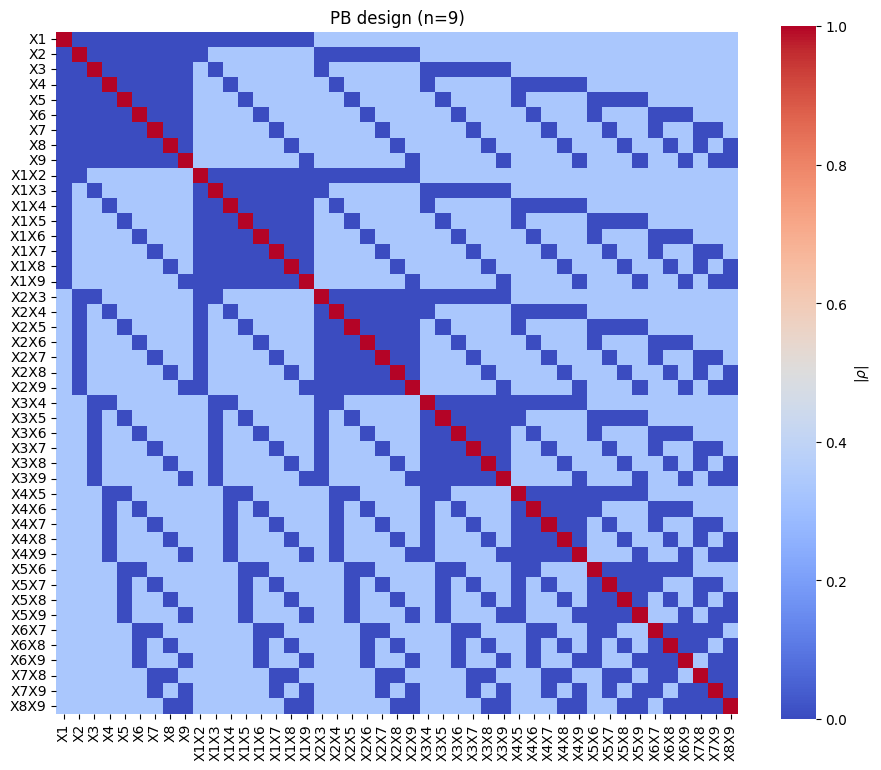

In [20]:
fig, ax = plt.subplots(figsize=(11, 9))

correlation_heatmap(
    design=PlackettBurman, n_factor=9, ax=ax,
    **heatmap_pref
)

if conf.savefig:
    fig.savefig(f"{conf.out}/pb_corr_n={n_factor}.pdf", **kwarg_savefig)

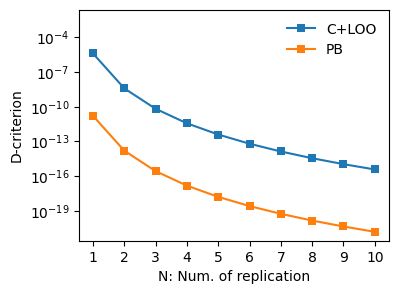

In [21]:
fig, ax = plt.subplots(figsize=(4, 3))

n_rep = 10

cloo = [pd.concat([CLOO().get_exmatrix(9)()] * (i + 1)) for i in range(n_rep)]
pb = [pd.concat([PlackettBurman().get_exmatrix(9)()] * (i + 1)) for i in range(n_rep)]

sns.lineplot(
    x=np.arange(1, n_rep + 1),
    y=np.fromiter(map(d_criterion, map(sm.add_constant, cloo)), float),
    label="C+LOO", color="C0", marker="s", markeredgewidth=0,
)

sns.lineplot(
    x=np.arange(1, n_rep + 1),
    y=np.fromiter(map(d_criterion, map(sm.add_constant, pb)), float),
    label="PB", color="C1", marker="s", markeredgewidth=0,
)

ax.set_xticks(np.arange(1, n_rep + 1), np.arange(1, n_rep + 1).astype(int))
ax.set_yscale("log")
ax.set_ylim(np.array(ax.get_ylim()) * np.array([1, 1000]))
ax.legend(loc="upper right", frameon=False)
ax.set(xlabel="N: Num. of replication", ylabel="D-criterion")

if conf.savefig:
    fig.savefig(f"{conf.out}/benchmark_d.pdf", **kwarg_savefig)

---
# Full Factorial

/home/jovyan/jupyternb/doe_modules/plot/_design_matrix.py:29: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=dsm.applymap(


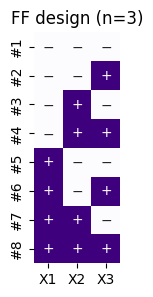

In [22]:
for n_factor in np.arange(2, 6):
    
    figsize = [(3, 3)] * 2 + [(3, 9)] * 2
    
    if n_factor == 3: 

        fig, ax = plt.subplots(figsize=figsize[n_factor - 2])

        design_heatmap(
            design=FullFactorial, n_factor=n_factor, ax=ax,
            **dsmat_pref
        )

        if conf.savefig:
            fig.savefig(f"{conf.out}/ff_n={n_factor}.pdf", **kwarg_savefig)

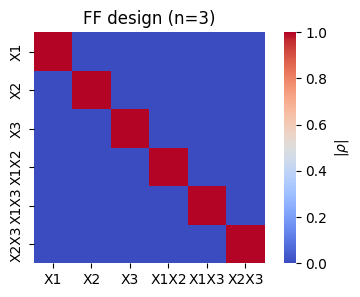

In [23]:
for n_f in np.arange(2, 6):
    
    if n_f == 3: 
        fig, ax = plt.subplots(figsize=(n_f+2, n_f))

        correlation_heatmap(
            design=FullFactorial, n_factor=n_f, ax=ax,
            **heatmap_pref
        )

        if conf.savefig:
            fig.savefig(f"{conf.out}/ff_corr_n={n_f}.pdf", **kwarg_savefig)

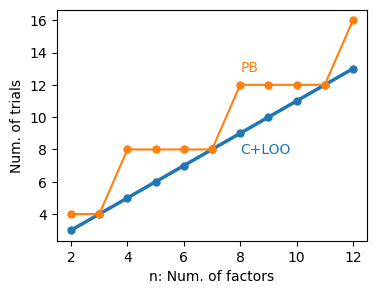

In [24]:
fig, ax = plt.subplots(figsize=(4, 3))

n_cloo = np.vectorize(lambda x: x + 1)
n_pb = np.vectorize(lambda x: 4 * (x // 4 + 1))
n_cloo2 = np.vectorize(lambda x: 2 * (x + 1))
n_pb2 = np.vectorize(lambda x: 8 * (x // 4 + 1))
n_cloo3 = np.vectorize(lambda x: 3 * (x + 1))
n_pb3 = np.vectorize(lambda x: 12 * (x // 4 + 1))

lim = 12

m = n[1:lim]

ax.plot(m, n_cloo(m), marker="o", markersize=5, label="C+LOO", linewidth=2.5)
ax.plot(m, n_pb(m), marker="o", markersize=5, label="PB")

ax.text(8, n_cloo(8) - .6, "C+LOO", ha="left", va="top", color="C0")
ax.text(8, n_pb(8) + .6, "PB", ha="left", va="bottom", color="C1")

ax.set(ylabel="Num. of trials", xlabel="n: Num. of factors")

if conf.savefig:
        fig.savefig(f"{conf.out}/n_max.pdf", **kwarg_savefig)

---
# D-optimization

/home/jovyan/jupyternb/doe_modules/plot/_design_matrix.py:29: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=dsm.applymap(


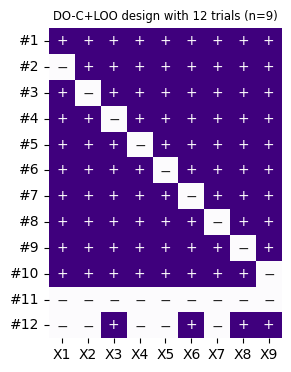

In [25]:
fig, ax = plt.subplots(figsize=(3, 6))

n_factor = 9
n_trials = 12

design_heatmap(
    design=DOCLOO, n_factor=n_factor, ax=ax,
    design_kws={"n_total": n_trials},
    **dsmat_pref
)

ax.set_title(ax.get_title(), fontsize="small")

if conf.savefig:
    fig.savefig(f"{conf.out}/doptim_{n_trials}trials.pdf", **kwarg_savefig)

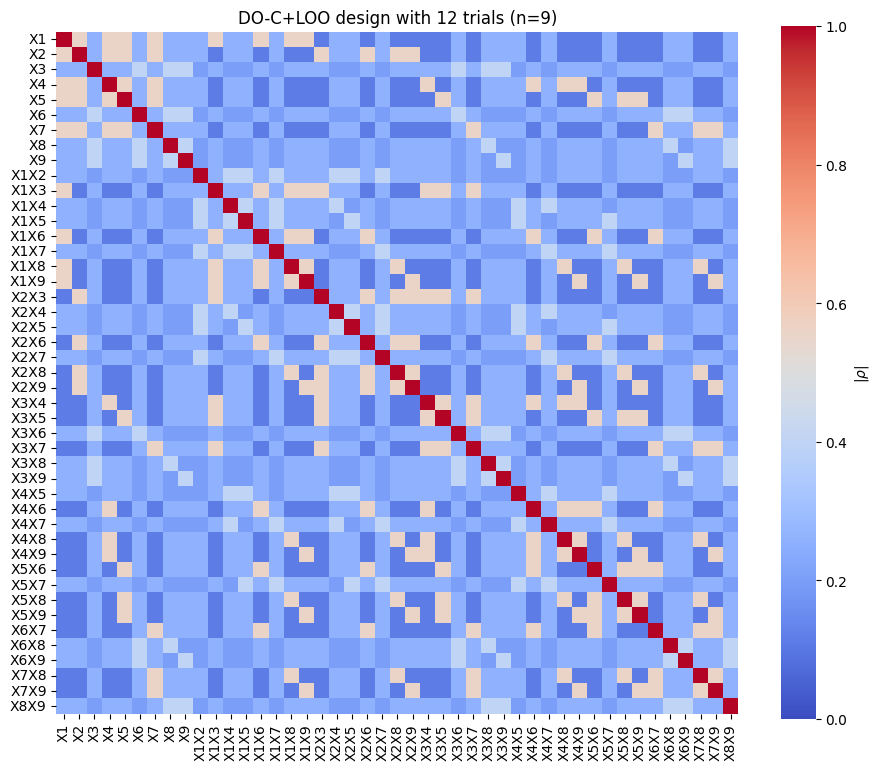

In [26]:
fig, ax = plt.subplots(figsize=(11, 9))

correlation_heatmap(
    design=DOCLOO, n_factor=9, ax=ax,
    design_kws={"n_total": 12},
    **heatmap_pref
)

if conf.savefig:
    fig.savefig(f"{conf.out}/corr_doptim_{n_trials}trials.pdf", **kwarg_savefig)

In [27]:
lst_mat = [
    CLOO().get_exmatrix(9).values
] + [
    DOCLOO().get_exmatrix(9, i + 1).values for i in range(40)
]

In [28]:
lst_pb = [
    PlackettBurman().get_exmatrix(9).values
] + [
    DOptimization(
        base=PlackettBurman
    ).get_exmatrix(9, i + 1).values for i in range(38)
]

In [29]:
duplicate = lambda arr: np.vstack([arr] * 2)
triplicate = lambda arr: np.vstack([arr] * 3)

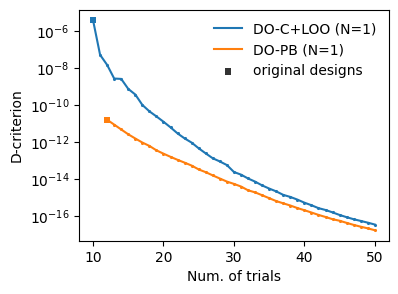

In [30]:
fig, ax = plt.subplots(figsize=(4, 3))

sns.lineplot(
    x=np.arange(10, 51),
    y=np.fromiter(map(d_criterion, map(sm.add_constant, lst_mat)), float),
    label="DO-C+LOO (N=1)", color="C0",
    linewidth=1.5
)
sns.scatterplot(
    x=np.arange(10, 51)[1:],
    y=np.fromiter(map(d_criterion, map(sm.add_constant, lst_mat)), float)[1:],
    color="C0", marker="o", s=5,
    linewidth=0
)

sns.lineplot(
    x=np.arange(12, 51),
    y=np.fromiter(map(d_criterion, map(sm.add_constant, lst_pb)), float),
    label="DO-PB (N=1)", color="C1", 
    linewidth=1.5
)

sns.scatterplot(
    x=np.arange(12, 51)[1:],
    y=np.fromiter(map(d_criterion, map(sm.add_constant, lst_pb)), float)[1:],
    color="C1", marker="o", s=5,
    linewidth=0
)

originals = [lst_mat[0], lst_mat[0], lst_pb[0]]

sns.scatterplot(
    x=[10, 10, 12], 
    y=np.fromiter(map(d_criterion, map(sm.add_constant, originals)), dtype=float),
    color=[".2", "C0", "C1"], marker=",", s=20,
    linewidth=0, label="original designs"
)

ax.set(xlabel="Num. of trials", ylabel="D-criterion")
ax.set_yscale("log")

ax.legend(frameon=False)

xlim = ax.get_xlim()

if conf.savefig:
    fig.savefig(f"{conf.out}/doptim.pdf", **kwarg_savefig)

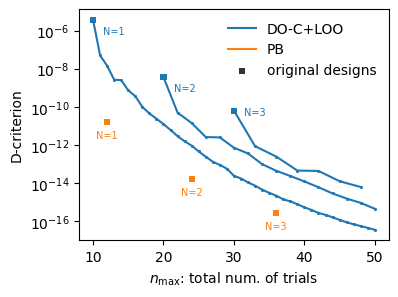

In [31]:
fig, ax = plt.subplots(figsize=(4, 3))

sns.lineplot(
    x=np.arange(10, 51),
    y=np.fromiter(map(d_criterion, map(sm.add_constant, lst_mat)), float),
    color="C0"
    # , linewidth=1
)

sns.scatterplot(
    x=np.arange(10, 51)[1:],
    y=np.fromiter(map(d_criterion, map(sm.add_constant, lst_mat)), float)[1:],
    color="C0", marker="o", s=5, linewidth=0
)

sns.lineplot(
    x=np.arange(10, 51)[:16] * 2,
    y=np.fromiter(map(d_criterion, map(duplicate, map(sm.add_constant, lst_mat))), float)[:16],
    color="C0"
    # , linewidth=2
)

sns.scatterplot(
    x=np.arange(10, 51)[1:16] * 2,
    y=np.fromiter(map(d_criterion, map(duplicate, map(sm.add_constant, lst_mat))), float)[1:16],
    color="C0", marker="o", s=5, linewidth=0
)

sns.lineplot(
    x=np.arange(10, 51)[:7] * 3,
    y=np.fromiter(map(d_criterion, map(triplicate, map(sm.add_constant, lst_mat))), float)[:7],
    color="C0"
    # , linewidth=3
)

sns.scatterplot(
    x=np.arange(10, 51)[1:7] * 3,
    y=np.fromiter(map(d_criterion, map(triplicate, map(sm.add_constant, lst_mat))), float)[1:7],
    color="C0", marker="o", s=5, linewidth=0
)

sns.lineplot(x=[0], y=[0], label="DO-C+LOO", color="C0",)
sns.lineplot(x=[0], y=[0], label="PB", color="C1",)

originals = [
    sm.add_constant(lst_mat[0])
] * 2 + [
    duplicate(sm.add_constant(lst_mat[0])), 
    triplicate(sm.add_constant(lst_mat[0]))
] + [
    sm.add_constant(lst_pb[0]),
    duplicate(sm.add_constant(lst_pb[0])),
    triplicate(sm.add_constant(lst_pb[0]))
]

sns.scatterplot(
    x=[10, 10, 20, 30, 12, 24, 36], 
    y=np.fromiter(map(d_criterion, originals), dtype=float),
    color=[".2"] + ["C0"] * 3 + ["C1"] * 3, marker=",", s=20,
    linewidth=0, label="original designs"
)

y = ax.get_ylim()

pb_temp = [sm.add_constant(lst_pb[0]), duplicate(sm.add_constant(lst_pb[0])), triplicate(sm.add_constant(lst_pb[0]))]

texts = ["N=1", "N=2", "N=3"] * 2
xs2 = [13, 23, 33, 12, 24, 36]
ys2 = [1e-6, 1e-9, 5e-11] + list(np.fromiter(map(d_criterion, pb_temp), float) / 5)
identifier = ["do"] * 3 + ["pb"] * 3

for x, y, t, idf in zip(xs2, ys2, texts, identifier):
    ax.text(x, y, t, size=7, ha="center", va="center", zorder=11, c="C0" if idf == "do" else "C1")

ax.set_xlim(xlim)

ax.set(
    ylabel="D-criterion", 
    xlabel="$n_{\max}$: total num. of trials"
)

ax.legend(frameon=False)

ax.set_yscale("log")

if conf.savefig:
    fig.savefig(f"{conf.out}/doptim_nrep.pdf", **kwarg_savefig)

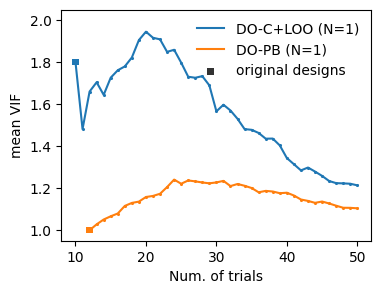

In [96]:
fig, ax = plt.subplots(figsize=(4, 3))

sns.lineplot(
    x=np.arange(10, 51),
    y=np.fromiter(map(lambda mat: np.mean([vif(mat, i + 1) for i in range(9)]), map(sm.add_constant, lst_mat)), float),
    color="C0", label="DO-C+LOO (N=1)", 
    # , linewidth=1
)

sns.scatterplot(
    x=np.arange(10, 51)[1:],
    y=np.fromiter(map(lambda mat: np.mean([vif(mat, i + 1) for i in range(9)]), map(sm.add_constant, lst_mat)), float)[1:],
    color="C0", marker="o", s=5, linewidth=0
)

sns.lineplot(
    x=np.arange(12, 51),
    y=np.fromiter(map(lambda mat: np.mean([vif(mat, i + 1) for i in range(9)]), map(sm.add_constant, lst_pb)), float),
    color="C1", label="DO-PB (N=1)", 
    # , linewidth=1
)

sns.scatterplot(
    x=np.arange(12, 51)[1:],
    y=np.fromiter(map(lambda mat: np.mean([vif(mat, i + 1) for i in range(9)]), map(sm.add_constant, lst_pb)), float)[1:],
    color="C1", marker="o", s=5, linewidth=0
)

originals = [
    sm.add_constant(lst_mat[0])
] * 2 + [
    sm.add_constant(lst_pb[0]),
]

sns.scatterplot(
    x=[10, 10, 12], 
    y=np.fromiter(map(lambda mat: np.array([vif(mat, i + 1) for i in range(9)]).max(), originals), dtype=float),
    color=[".2"] + ["C0"] + ["C1"], marker=",", s=20,
    linewidth=0, label="original designs"
)

ax.set_xlim(xlim)
ax.set_ylim(.95, 2.05)

ax.set(
    ylabel="mean VIF", 
    xlabel="Num. of trials"
)

ax.legend(frameon=False)

# ax.set_yscale("log")

# if conf.savefig:
#     fig.savefig(f"{conf.out}/doptim_nrep_vif.pdf", **kwarg_savefig)

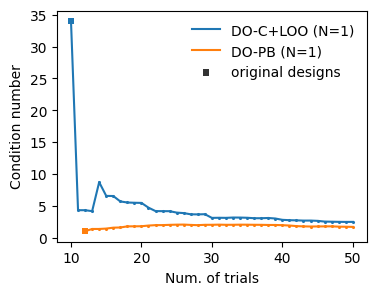

In [98]:
fig, ax = plt.subplots(figsize=(4, 3))

sns.lineplot(
    x=np.arange(10, 51),
    y=np.fromiter(map(np.linalg.cond, map(sm.add_constant, lst_mat)), float),
    color="C0", label="DO-C+LOO (N=1)",
    # , linewidth=1
)

sns.scatterplot(
    x=np.arange(10, 51)[1:],
    y=np.fromiter(map(np.linalg.cond, map(sm.add_constant, lst_mat)), float)[1:],
    color="C0", marker="o", s=5, linewidth=0
)

sns.lineplot(
    x=np.arange(12, 51),
    y=np.fromiter(map(np.linalg.cond, map(sm.add_constant, lst_pb)), float),
    color="C1", label="DO-PB (N=1)",
    # , linewidth=1
)

sns.scatterplot(
    x=np.arange(12, 51)[1:],
    y=np.fromiter(map(np.linalg.cond, map(sm.add_constant, lst_pb)), float)[1:],
    color="C1", marker="o", s=5, linewidth=0
)

originals = [
    sm.add_constant(lst_mat[0])
] * 2 + [
    sm.add_constant(lst_pb[0])
]

sns.scatterplot(
    x=[10, 10, 12], 
    y=np.fromiter(map(np.linalg.cond, originals), dtype=float),
    color=[".2"] + ["C0"] + ["C1"], marker=",", s=20,
    linewidth=0, label="original designs"
)

y = ax.get_ylim()

pb_temp = [sm.add_constant(lst_pb[0]), duplicate(sm.add_constant(lst_pb[0])), triplicate(sm.add_constant(lst_pb[0]))]

texts = ["N=1", "N=2", "N=3"] * 2
xs2 = [13, 23, 33, 12, 24, 36]
ys2 = [1e-6, 1e-9, 5e-11] + list(np.fromiter(map(np.linalg.cond, pb_temp), float) / 5)
identifier = ["do"] * 3 + ["pb"] * 3

# for x, y, t, idf in zip(xs2, ys2, texts, identifier):
#     ax.text(x, y, t, size=7, ha="center", va="center", zorder=11, c="C0" if idf == "do" else "C1")

ax.set_xlim(xlim)
# ax.set_ylim(-1.5, 51.5)

ax.set(
    ylabel="Condition number", 
    xlabel="Num. of trials"
)

ax.legend(frameon=False)

# ax.set_yscale("log")

# if conf.savefig:
#     fig.savefig(f"{conf.out}/doptim_nrep_cond.pdf", **kwarg_savefig)